In [390]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [391]:
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [392]:
randomData = []
randomLabels = []
for i in range(5000):
    value1 = random.randint(0,2)
    value2 = random.randint(0,2)
    value3 = random.randint(0,2)
    value4 = random.randint(0,2)
    randomData.append([value1, value2, value3])
    randomLabels.append(value4)

In [393]:
randomTestData = []
randomTestLabels = []
for i in range(500):
    value1 = random.randint(0,2)
    value2 = random.randint(0,2)
    value3 = random.randint(0,2)
    value4 = random.randint(0,2)
    randomTestData.append([value1, value2, value3])
    randomTestLabels.append(value4)

In [418]:
data = np.load("rps_data.npy")
labels = data[1:, 0]
data = data[:len(data)-1]
trainingData = data[:450, :]
testData = data[450:, :]
trainingLabels = labels[:450]
testLabels = labels[450:]


FileNotFoundError: [Errno 2] No such file or directory: 'rps_data.npy'

In [419]:
np.save("rps_data.npy", data)
np.save("rps_labels.npy", labels)

In [395]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.LSTM = nn.LSTM(1, 1000, batch_first=True, num_layers=1)
        self.FC1 = nn.Linear(1000, 2000)
        self.FC2 = nn.Linear(2000, 3)
        self.dropout = nn.Dropout()
        

    def forward(self, x):
        lstmOutput, _ = self.LSTM(x)
        x = F.relu(self.FC1(lstmOutput[:, -1, :]))
        x = self.dropout(x)
        x = self.FC2(x)
        x = F.softmax(x)
        return x

net = Net().to(device)
print(net)

Net(
  (LSTM): LSTM(1, 1000, batch_first=True)
  (FC1): Linear(in_features=1000, out_features=2000, bias=True)
  (FC2): Linear(in_features=2000, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [396]:
def train(data, labels, net: nn.Module):
    lossFunction = nn.CrossEntropyLoss()
    lossList = []
    accuracyList = []
    epochs = 10
    batchSize = 100
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
    optimizer.zero_grad()

    for _ in tqdm(range(epochs)):
        for batchNumber in range(int(len(data) / batchSize)):
            start = batchNumber * batchSize
            currentData = data[start:start+batchSize, :, :]
            currentLabels = labels[start:start+batchSize]
            
            inputData = torch.FloatTensor(currentData).to(device)
            inputData.requires_grad_()
            outputData = torch.LongTensor(currentLabels).to(device)
            currentPredictions = net(inputData)

            currentLoss = lossFunction(currentPredictions, outputData)

            currentLoss.backward()

            optimizer.step()

            optimizer.zero_grad()

            lossList.append(currentLoss.item())

            accuracyList.append((currentPredictions.argmax(1) == outputData).type(torch.float).sum().item() / batchSize)
    
    return lossList, accuracyList

In [397]:
d = np.array(randomData)
d = d.reshape(d.shape[0], d.shape[1], 1)
print(d.shape)

(5000, 3, 1)


In [400]:
def test(testData, testLabels, net):
    net.eval()
    batchSize = 25
    correct = 0
    with torch.no_grad():
        for batchNumber in range(int(len(testData) / batchSize)):
            start = batchNumber * batchSize

            currentData = testData[start:start+batchSize, :]

            currentData = torch.FloatTensor(currentData).to(device)

            currentLabels = testLabels[start:start+batchSize]
            currentLabels = torch.LongTensor(currentLabels).to(device)
            
            prediction = net(currentData)

            correct += (prediction.argmax(1) == currentLabels).type(torch.float).sum().item()
    return correct / len(testLabels)

In [403]:
actualTest = np.array(testData)

In [405]:
actualData = np.array(trainingData)
actualData = actualData.reshape(actualData.shape[0], actualData.shape[1], 1)
print(actualData.shape)

(450, 3, 1)


In [406]:
lossList, accList = train(actualData, np.array(trainingLabels), net)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_73517/411051272.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


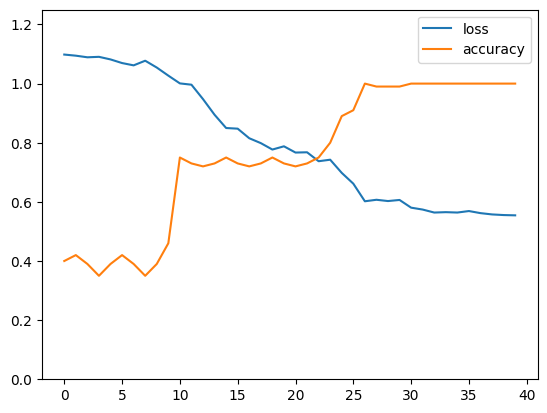

In [407]:
plt.plot(range(len(lossList)), lossList, range(len(accList)), accList)
plt.legend(['loss', 'accuracy'])
plt.ylim((0,1.25))
plt.show()

In [408]:
print("Accuracy:", str(test(actualTest.reshape(actualTest.shape[0], actualTest.shape[1], 1), np.array(testLabels), net)))

Accuracy: 0.5102040816326531


/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_73517/411051272.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [417]:
net.eval()
t = np.array([[0, 1, 2]]).reshape(1,3,1)
print(net(torch.FloatTensor(t)).argmax(1))

tensor([1])


/var/folders/m2/vd7bhy010wv4jcz0_pttj9l40000gn/T/ipykernel_73517/411051272.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [409]:
net_script = torch.jit.script(net)
net_script.save("rps_game_ai.pt")

In [421]:
new_data = np.load("rps_data.npy")
new_labels = np.load("rps_labels.npy")
print(new_data.shape)
print(new_labels.shape)

(549, 3)
(549,)
